In [39]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [40]:
import yfinance as yf

data = yf.download(tickers = "NEM", start="2017-12-01", end="2023-06-16", interval='1d')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,37.070000,37.610001,36.779999,37.189999,31.313105,5074400
2017-12-04,37.240002,37.240002,36.660000,36.840000,31.018412,3777300
2017-12-05,36.599998,36.799999,36.070000,36.200001,30.479542,5984100
2017-12-06,36.250000,36.400002,35.779999,35.830002,30.168018,5797400
2017-12-07,35.529999,36.130001,35.450001,35.919998,30.307234,4047700
...,...,...,...,...,...,...
2023-06-09,41.930000,42.009998,41.290001,41.459999,41.459999,5601300
2023-06-12,41.400002,42.070000,41.279999,42.040001,42.040001,6618100
2023-06-13,42.250000,42.549999,42.090000,42.439999,42.439999,7955900


In [41]:
data = data.reset_index('Date', inplace=False)

In [42]:
# Chuyển cột 'Date' thành kiểu dữ liệu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Sắp xếp dữ liệu theo thứ tự tăng dần của cột 'Date'
data.sort_values(by='Date', inplace=True)

# Chuyển cột 'Date' thành mảng numpy
dates = data['Date'].values

# Chuyển cột 'Close' thành mảng numpy
close_prices = data['Close'].values

In [43]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [44]:
train_dates = train_data['Date'].values
train_close_prices = train_data['Close'].values
val_dates = val_data['Date'].values
val_close_prices = val_data['Close'].values
test_dates = test_data['Date'].values
test_close_prices = test_data['Close'].values

In [45]:
train_dates = train_data.index.values
test_dates = test_data.index.values
val_dates = val_data.index.values

In [46]:
X_train = torch.from_numpy(train_dates.reshape(-1, 1)).float()
y_train = torch.from_numpy(train_close_prices.reshape(-1, 1)).float()
X_test = torch.from_numpy(test_dates.reshape(-1, 1)).float()
y_test = torch.from_numpy(test_close_prices.reshape(-1, 1)).float()
X_val = torch.from_numpy(val_dates.reshape(-1, 1)).float()
y_val = torch.from_numpy(val_close_prices.reshape(-1, 1)).float()

In [47]:
# Xác định kiến trúc của mạng Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
# Xác định hàm mất mát và bộ tối ưu hóa
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 1000

In [49]:
# Khởi tạo mô hình BNN
model = BNN(input_size=1, output_size=1)

In [50]:
# Huấn luyện mô hình BNN
for epoch in range(num_epochs):
    model.train()

    # Tính đầu ra dự đoán của mô hình
    y_pred = model(X_train)

    # Tính lỗi dự đoán so với giá thực tế
    loss = criterion(y_pred, y_train)

    # Backpropagation và cập nhật trọng số
    loss.backward()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [100/1000], Loss: 3370.92041015625
Epoch [200/1000], Loss: 940.8895874023438
Epoch [300/1000], Loss: 945.3328857421875
Epoch [400/1000], Loss: 269.35089111328125
Epoch [500/1000], Loss: 729.904541015625
Epoch [600/1000], Loss: 246.3148651123047
Epoch [700/1000], Loss: 292.7687683105469
Epoch [800/1000], Loss: 488.6167907714844
Epoch [900/1000], Loss: 299.9515380859375
Epoch [1000/1000], Loss: 233.8855438232422


In [51]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)

In [52]:
# Dự đoán trên tập validation
model.eval()
with torch.no_grad():
    y_pred_val = model(X_val)

In [53]:
# In kết quả dự đoán trên tập test
print('Kết quả dự đoán trên tập test:')
for i in range(len(test_dates)):
    print(f'Date: {test_dates[i]}, Predicted Close: {y_pred_test[i].item()}')

Kết quả dự đoán trên tập test:
Date: 975, Predicted Close: 83.98118591308594
Date: 976, Predicted Close: 84.065673828125
Date: 977, Predicted Close: 84.150146484375
Date: 978, Predicted Close: 84.23463439941406
Date: 979, Predicted Close: 84.31908416748047
Date: 980, Predicted Close: 84.40357971191406
Date: 981, Predicted Close: 84.4880599975586
Date: 982, Predicted Close: 84.5725326538086
Date: 983, Predicted Close: 84.65699768066406
Date: 984, Predicted Close: 84.74147033691406
Date: 985, Predicted Close: 84.82594299316406
Date: 986, Predicted Close: 84.91044616699219
Date: 987, Predicted Close: 84.99490356445312
Date: 988, Predicted Close: 85.07939147949219
Date: 989, Predicted Close: 85.16387939453125
Date: 990, Predicted Close: 85.24833679199219
Date: 991, Predicted Close: 85.33282470703125
Date: 992, Predicted Close: 85.41729736328125
Date: 993, Predicted Close: 85.50178527832031
Date: 994, Predicted Close: 85.58627319335938
Date: 995, Predicted Close: 85.67072296142578
Date: 996

In [54]:
# In kết quả dự đoán trên tập validation
print('Kết quả dự đoán trên tập validation:')
for i in range(len(val_dates)):
    print(f'Date: {val_dates[i]}, Predicted Close: {y_pred_val[i].item()}')


Kết quả dự đoán trên tập validation:
Date: 1253, Predicted Close: 107.46582794189453
Date: 1254, Predicted Close: 107.5503158569336
Date: 1255, Predicted Close: 107.63481140136719
Date: 1256, Predicted Close: 107.7192611694336
Date: 1257, Predicted Close: 107.80377197265625
Date: 1258, Predicted Close: 107.88823699951172
Date: 1259, Predicted Close: 107.97270965576172
Date: 1260, Predicted Close: 108.05718231201172
Date: 1261, Predicted Close: 108.14165496826172
Date: 1262, Predicted Close: 108.22614288330078
Date: 1263, Predicted Close: 108.31061553955078
Date: 1264, Predicted Close: 108.39510345458984
Date: 1265, Predicted Close: 108.47956848144531
Date: 1266, Predicted Close: 108.56405639648438
Date: 1267, Predicted Close: 108.64852905273438
Date: 1268, Predicted Close: 108.73300170898438
Date: 1269, Predicted Close: 108.81747436523438
Date: 1270, Predicted Close: 108.90196228027344
Date: 1271, Predicted Close: 108.98644256591797
Date: 1272, Predicted Close: 109.0708999633789
Date: 

In [55]:
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
#x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

x_next_30_days = torch.from_numpy(np.array(range(last_index+1, last_index+31)).reshape(-1, 1)).float()
# Dự đoán giá đóng cửa cho 30 ngày tiếp theo
model.eval()
with torch.no_grad():
    y_pred_next = model(x_next_30_days)

# Chuyển đổi kết quả dự đoán thành mảng numpy
y_pred_next = y_pred_next.numpy().flatten()

# Hiển thị kết quả dự đoán
for i in range(len(x_next_30_days)):
    print(f'Date: {x_next_30_days[i]}, Predicted Close: {y_pred_next[i]}')

Date: tensor([1393.]), Predicted Close: 119.29264831542969
Date: tensor([1394.]), Predicted Close: 119.37713623046875
Date: tensor([1395.]), Predicted Close: 119.46159362792969
Date: tensor([1396.]), Predicted Close: 119.54608154296875
Date: tensor([1397.]), Predicted Close: 119.63055419921875
Date: tensor([1398.]), Predicted Close: 119.71504211425781
Date: tensor([1399.]), Predicted Close: 119.79950714111328
Date: tensor([1400.]), Predicted Close: 119.88397979736328
Date: tensor([1401.]), Predicted Close: 119.96845245361328
Date: tensor([1402.]), Predicted Close: 120.05294036865234
Date: tensor([1403.]), Predicted Close: 120.13743591308594
Date: tensor([1404.]), Predicted Close: 120.2219009399414
Date: tensor([1405.]), Predicted Close: 120.30635833740234
Date: tensor([1406.]), Predicted Close: 120.3908462524414
Date: tensor([1407.]), Predicted Close: 120.475341796875
Date: tensor([1408.]), Predicted Close: 120.55982208251953
Date: tensor([1409.]), Predicted Close: 120.644287109375
Dat

In [56]:
y_pred_test.type(),y_test.shape

('torch.FloatTensor', torch.Size([278, 1]))

In [57]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(torch.mean((y_pred_test - y_test)**2))
valid_rmse = np.sqrt(torch.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred_test, y_test)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: tensor(41.0318)
Validation RMSE: tensor(66.3368)
Testing MAE: 37.470524
Validation MAE: 66.076584
Testing MAPE: 0.38410094
Validation MAPE: 1.4138064


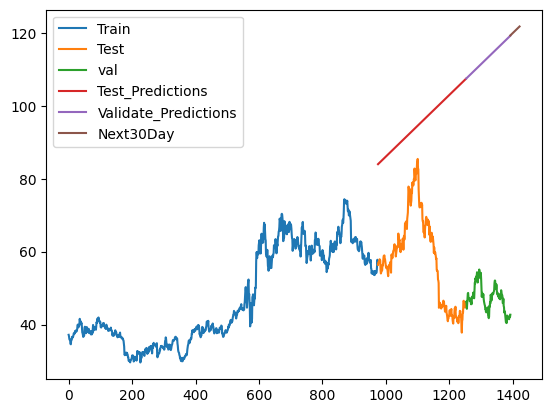

In [58]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data, y_pred_next)
plt.legend(['Train', 'Test','val', 'Test_Predictions','Validate_Predictions','Next30Day'])
plt.show()